In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [4]:
from torch.utils.data import  Dataset
from PIL import Image
import random

## Part 1. Loading data

In [5]:
data_path = "/kaggle/input/faces-dataset-small/faces_dataset_small"

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')  
        if self.transform:
            image = self.transform(image)
        return image  # No label as it's a single-class dataset

In [7]:
def get_dataloader(image_size, batch_size):
    """
    Builds a DataLoader for training data with transformations.
    
    :param image_size: height and width of the image
    :param batch_size: batch size of the DataLoader
    :param data_dir: directory where the image data is located
    :returns: DataLoader object
    """
    transform = tt.Compose([
        tt.Resize((image_size, image_size)),  
        tt.ToTensor(),  
    ])
    

    dataset = CustomImageDataset(img_dir=data_path, transform=transform)
    print(len(dataset))
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)
    
    return dataloader

In [8]:
image_size = 128
batch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_loader = get_dataloader(image_size=image_size, batch_size=batch_size)


3143


In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
train_dl = DeviceDataLoader(dataset_loader, device)

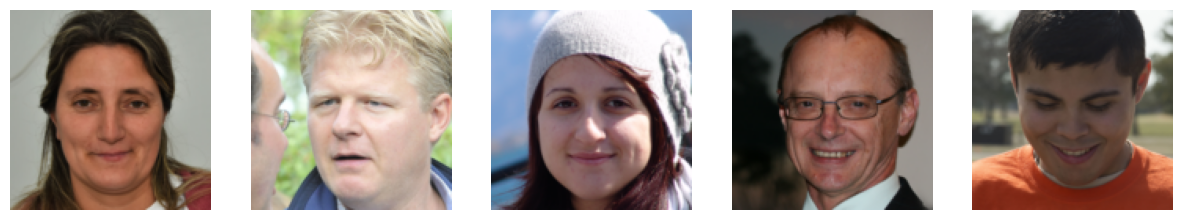

In [11]:
batch = next(iter(dataset_loader))
random_indices = random.sample(range(len(batch)), 5)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    img = batch[idx].permute(1, 2, 0) 
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


## Part 2. Building and training model

In [12]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

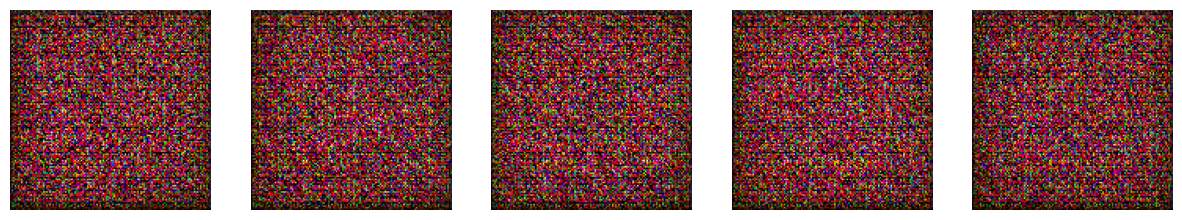

In [14]:
xb = torch.randn(32, latent_size, 1, 1) 
fake_images = generator(xb)

random_indices = random.sample(range(len(fake_images)), 5)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    img = fake_images[idx].permute(1, 2, 0) 
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.detach().numpy())
    plt.axis('off')

plt.show()

### Training

We are using Binary Cross-Entropy loss.

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [16]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [17]:
sample_dir = '/kaggle/working/generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [18]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=128):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=128):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [19]:
def train_discriminator(model, criterion, optimizer, real_images):
    # Clear discriminator gradients
    optimizer["discriminator"].zero_grad()
    real_preds = model["discriminator"](real_images)

    real_targets = torch.ones(real_images.size(0), real_preds.size(1), device=device)
    real_loss = criterion["discriminator"](real_preds, real_targets)
    cur_real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = model["generator"](latent)
            
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), real_preds.size(1), device=device)
    fake_preds = model["discriminator"](fake_images)
    fake_loss = criterion["discriminator"](fake_preds, fake_targets)
    cur_fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss_d = real_loss + fake_loss
    loss_d.backward()
    optimizer["discriminator"].step()
    
    return cur_real_score, cur_fake_score, loss_d

In [20]:
def train_generator(model, criterion, optimizer, real_images):
    # Clear generator gradients
    optimizer["generator"].zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = model["generator"](latent)

    # Try to fool the discriminator
    preds = model["discriminator"](fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss_g = criterion["generator"](preds, targets)

    # Update generator weights
    loss_g.backward()
    optimizer["generator"].step()
    
    return loss_g
    

In [21]:
def fit(model, criterion, epochs, lr, start_idx=1, save_path="best_model.pth"):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    # Initialize best score trackers
    best_real_score = float('-inf')
    best_fake_score = float('inf')
    best_model = None

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for real_images in tqdm(train_dl):
            # Train discriminator
            cur_real_score, cur_fake_score, loss_d = train_discriminator(model, criterion, optimizer, real_images)

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)
            loss_d_per_epoch.append(loss_d.item())

            # Train generator
            loss_g = train_generator(model, criterion, optimizer, real_images)
            
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save best model based on scores
        if real_scores[-1] > best_real_score and fake_scores[-1] < best_fake_score:
            print(f"Saving best model at epoch {epoch+1}")
            best_real_score = real_scores[-1]
            best_fake_score = fake_scores[-1]
            best_model = {
                "discriminator": model["discriminator"].state_dict(),
                "generator": model["generator"].state_dict()
            }
            torch.save(best_model, save_path)

        # Save generated images at last epoch
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [22]:
history = fit(model, criterion, 500, 0.0002)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/500], loss_g: 9.3917, loss_d: 0.4625, real_score: 0.8971, fake_score: 0.1812
Saving best model at epoch 1


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/500], loss_g: 8.5546, loss_d: 0.1806, real_score: 0.9505, fake_score: 0.0533
Saving best model at epoch 2


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/500], loss_g: 7.6186, loss_d: 0.2426, real_score: 0.9304, fake_score: 0.0761


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/500], loss_g: 8.5397, loss_d: 0.3646, real_score: 0.9202, fake_score: 0.0709


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/500], loss_g: 5.3422, loss_d: 0.4688, real_score: 0.8587, fake_score: 0.1226


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/500], loss_g: 3.1513, loss_d: 0.8064, real_score: 0.7477, fake_score: 0.2357


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/500], loss_g: 2.7764, loss_d: 0.9698, real_score: 0.7065, fake_score: 0.2876


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/500], loss_g: 2.4044, loss_d: 1.0432, real_score: 0.6805, fake_score: 0.3179


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/500], loss_g: 2.6174, loss_d: 0.9542, real_score: 0.6869, fake_score: 0.3094


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/500], loss_g: 2.4374, loss_d: 0.9846, real_score: 0.6697, fake_score: 0.3306


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/500], loss_g: 2.6102, loss_d: 1.0004, real_score: 0.6705, fake_score: 0.3322


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/500], loss_g: 2.5550, loss_d: 0.9408, real_score: 0.6819, fake_score: 0.3165


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/500], loss_g: 2.9506, loss_d: 0.9232, real_score: 0.6843, fake_score: 0.3097


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/500], loss_g: 2.9455, loss_d: 0.9688, real_score: 0.6781, fake_score: 0.3217


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/500], loss_g: 2.8434, loss_d: 0.9909, real_score: 0.6668, fake_score: 0.3338


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/500], loss_g: 2.6878, loss_d: 0.9894, real_score: 0.6635, fake_score: 0.3291


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/500], loss_g: 2.7792, loss_d: 0.9613, real_score: 0.6713, fake_score: 0.3212


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/500], loss_g: 2.8754, loss_d: 0.8991, real_score: 0.6929, fake_score: 0.3063


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/500], loss_g: 3.0191, loss_d: 0.8849, real_score: 0.6968, fake_score: 0.3013


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/500], loss_g: 3.0839, loss_d: 0.8775, real_score: 0.7006, fake_score: 0.2917


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/500], loss_g: 3.0577, loss_d: 0.8512, real_score: 0.7054, fake_score: 0.2883


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/500], loss_g: 3.1651, loss_d: 0.8715, real_score: 0.7101, fake_score: 0.2857


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/500], loss_g: 3.1226, loss_d: 0.7902, real_score: 0.7295, fake_score: 0.2750


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/500], loss_g: 3.1536, loss_d: 0.7811, real_score: 0.7293, fake_score: 0.2648


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/500], loss_g: 3.2404, loss_d: 0.8032, real_score: 0.7303, fake_score: 0.2669


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/500], loss_g: 3.2352, loss_d: 0.7921, real_score: 0.7329, fake_score: 0.2622


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/500], loss_g: 3.4005, loss_d: 0.7684, real_score: 0.7437, fake_score: 0.2566


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/500], loss_g: 3.4891, loss_d: 0.7109, real_score: 0.7602, fake_score: 0.2404


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/500], loss_g: 3.4939, loss_d: 0.6787, real_score: 0.7736, fake_score: 0.2228


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/500], loss_g: 4.0920, loss_d: 0.6829, real_score: 0.7857, fake_score: 0.2125


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [31/500], loss_g: 4.1558, loss_d: 0.6567, real_score: 0.7945, fake_score: 0.2007


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [32/500], loss_g: 4.2913, loss_d: 0.6177, real_score: 0.8104, fake_score: 0.1863


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [33/500], loss_g: 4.3420, loss_d: 0.6044, real_score: 0.8147, fake_score: 0.1865


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [34/500], loss_g: 4.1985, loss_d: 0.4727, real_score: 0.8455, fake_score: 0.1551


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [35/500], loss_g: 5.0618, loss_d: 0.4840, real_score: 0.8450, fake_score: 0.1542


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [36/500], loss_g: 4.3332, loss_d: 0.5985, real_score: 0.8135, fake_score: 0.1800


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [37/500], loss_g: 4.1539, loss_d: 0.5193, real_score: 0.8350, fake_score: 0.1732


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [38/500], loss_g: 4.7210, loss_d: 0.5366, real_score: 0.8283, fake_score: 0.1658


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [39/500], loss_g: 4.8576, loss_d: 0.4578, real_score: 0.8479, fake_score: 0.1482


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [40/500], loss_g: 4.8576, loss_d: 0.4644, real_score: 0.8524, fake_score: 0.1508


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [41/500], loss_g: 4.9134, loss_d: 0.3950, real_score: 0.8638, fake_score: 0.1340


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [42/500], loss_g: 4.6150, loss_d: 0.4996, real_score: 0.8519, fake_score: 0.1491


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [43/500], loss_g: 5.0590, loss_d: 0.3940, real_score: 0.8753, fake_score: 0.1250


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [44/500], loss_g: 4.5076, loss_d: 0.4459, real_score: 0.8572, fake_score: 0.1445


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [45/500], loss_g: 4.6364, loss_d: 0.5045, real_score: 0.8403, fake_score: 0.1619


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [46/500], loss_g: 4.4924, loss_d: 0.4206, real_score: 0.8600, fake_score: 0.1301


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [47/500], loss_g: 4.7469, loss_d: 0.3641, real_score: 0.8832, fake_score: 0.1205


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [48/500], loss_g: 4.9022, loss_d: 0.3522, real_score: 0.8830, fake_score: 0.1157


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [49/500], loss_g: 5.0518, loss_d: 0.4241, real_score: 0.8685, fake_score: 0.1295


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [50/500], loss_g: 4.9937, loss_d: 0.3381, real_score: 0.8916, fake_score: 0.1089


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [51/500], loss_g: 5.2529, loss_d: 0.3348, real_score: 0.8965, fake_score: 0.1010


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [52/500], loss_g: 5.1405, loss_d: 0.3186, real_score: 0.8930, fake_score: 0.1083


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [53/500], loss_g: 4.8846, loss_d: 0.4252, real_score: 0.8690, fake_score: 0.1268


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [54/500], loss_g: 5.2716, loss_d: 0.3130, real_score: 0.9010, fake_score: 0.0990


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [55/500], loss_g: 5.1099, loss_d: 0.3374, real_score: 0.8916, fake_score: 0.1105


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [56/500], loss_g: 5.5285, loss_d: 0.2089, real_score: 0.9213, fake_score: 0.0788


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [57/500], loss_g: 5.4308, loss_d: 0.3865, real_score: 0.8843, fake_score: 0.1170


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [58/500], loss_g: 5.2832, loss_d: 0.4412, real_score: 0.8681, fake_score: 0.1293


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [59/500], loss_g: 5.0966, loss_d: 0.3625, real_score: 0.8888, fake_score: 0.1087


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [60/500], loss_g: 5.3482, loss_d: 0.2604, real_score: 0.9166, fake_score: 0.0816


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [61/500], loss_g: 5.1828, loss_d: 0.3119, real_score: 0.8975, fake_score: 0.1069


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [62/500], loss_g: 5.2016, loss_d: 0.2481, real_score: 0.9141, fake_score: 0.0848


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [63/500], loss_g: 5.6618, loss_d: 0.2651, real_score: 0.9127, fake_score: 0.0889


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [64/500], loss_g: 5.1943, loss_d: 0.3733, real_score: 0.8951, fake_score: 0.1012


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [65/500], loss_g: 5.1304, loss_d: 0.2740, real_score: 0.9081, fake_score: 0.0939


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [66/500], loss_g: 5.3015, loss_d: 0.2821, real_score: 0.9157, fake_score: 0.0842


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [67/500], loss_g: 5.2719, loss_d: 0.2606, real_score: 0.9145, fake_score: 0.0834


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [68/500], loss_g: 5.4752, loss_d: 0.2640, real_score: 0.9218, fake_score: 0.0795


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [69/500], loss_g: 5.7634, loss_d: 0.2754, real_score: 0.9109, fake_score: 0.0869


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [70/500], loss_g: 5.7369, loss_d: 0.2535, real_score: 0.9263, fake_score: 0.0748


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [71/500], loss_g: 5.8097, loss_d: 0.2245, real_score: 0.9186, fake_score: 0.0813


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [72/500], loss_g: 6.1606, loss_d: 0.3355, real_score: 0.9154, fake_score: 0.0801


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [73/500], loss_g: 5.7574, loss_d: 0.2289, real_score: 0.9193, fake_score: 0.0842


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [74/500], loss_g: 5.3637, loss_d: 0.4889, real_score: 0.8731, fake_score: 0.1269


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [75/500], loss_g: 5.6946, loss_d: 0.1444, real_score: 0.9399, fake_score: 0.0585


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [76/500], loss_g: 6.2121, loss_d: 0.2220, real_score: 0.9276, fake_score: 0.0737


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [77/500], loss_g: 6.0469, loss_d: 0.2829, real_score: 0.9261, fake_score: 0.0678


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [78/500], loss_g: 5.6787, loss_d: 0.3201, real_score: 0.8977, fake_score: 0.1016


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [79/500], loss_g: 5.6408, loss_d: 0.2369, real_score: 0.9216, fake_score: 0.0835


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [80/500], loss_g: 6.3637, loss_d: 0.0936, real_score: 0.9591, fake_score: 0.0382
Saving best model at epoch 80


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [81/500], loss_g: 5.6619, loss_d: 0.4415, real_score: 0.8861, fake_score: 0.1178


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [82/500], loss_g: 5.8507, loss_d: 0.2738, real_score: 0.9146, fake_score: 0.0868


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [83/500], loss_g: 5.6520, loss_d: 0.2732, real_score: 0.9163, fake_score: 0.0803


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [84/500], loss_g: 5.5347, loss_d: 0.2127, real_score: 0.9289, fake_score: 0.0705


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [85/500], loss_g: 5.9758, loss_d: 0.1844, real_score: 0.9449, fake_score: 0.0554


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [86/500], loss_g: 6.0858, loss_d: 0.2090, real_score: 0.9266, fake_score: 0.0727


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [87/500], loss_g: 5.1715, loss_d: 0.3846, real_score: 0.8831, fake_score: 0.1148


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [88/500], loss_g: 5.7416, loss_d: 0.2066, real_score: 0.9287, fake_score: 0.0719


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [89/500], loss_g: 5.7508, loss_d: 0.1693, real_score: 0.9417, fake_score: 0.0578


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [90/500], loss_g: 6.4250, loss_d: 0.0828, real_score: 0.9643, fake_score: 0.0357
Saving best model at epoch 90


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [91/500], loss_g: 6.3318, loss_d: 0.2987, real_score: 0.9138, fake_score: 0.0859


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [92/500], loss_g: 5.9362, loss_d: 0.3057, real_score: 0.9069, fake_score: 0.0937


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [93/500], loss_g: 5.8520, loss_d: 0.2972, real_score: 0.9162, fake_score: 0.0829


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [94/500], loss_g: 5.7803, loss_d: 0.2089, real_score: 0.9255, fake_score: 0.0701


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [95/500], loss_g: 6.2208, loss_d: 0.2233, real_score: 0.9277, fake_score: 0.0761


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [96/500], loss_g: 6.0733, loss_d: 0.1213, real_score: 0.9523, fake_score: 0.0490


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [97/500], loss_g: 6.0487, loss_d: 0.3980, real_score: 0.8957, fake_score: 0.1046


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [98/500], loss_g: 5.4236, loss_d: 0.3553, real_score: 0.9058, fake_score: 0.0909


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [99/500], loss_g: 5.6173, loss_d: 0.1710, real_score: 0.9392, fake_score: 0.0651


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [100/500], loss_g: 6.2660, loss_d: 0.0860, real_score: 0.9643, fake_score: 0.0375


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [101/500], loss_g: 6.4714, loss_d: 0.1615, real_score: 0.9398, fake_score: 0.0551


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [102/500], loss_g: 6.4721, loss_d: 0.1514, real_score: 0.9580, fake_score: 0.0435


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [103/500], loss_g: 6.3497, loss_d: 0.2060, real_score: 0.9326, fake_score: 0.0676


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [104/500], loss_g: 6.4117, loss_d: 0.3281, real_score: 0.9110, fake_score: 0.0914


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [105/500], loss_g: 5.8582, loss_d: 0.1583, real_score: 0.9397, fake_score: 0.0574


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [106/500], loss_g: 6.3194, loss_d: 0.1500, real_score: 0.9462, fake_score: 0.0526


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [107/500], loss_g: 6.1333, loss_d: 0.2699, real_score: 0.9197, fake_score: 0.0760


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [108/500], loss_g: 4.7759, loss_d: 0.3080, real_score: 0.8955, fake_score: 0.1054


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [109/500], loss_g: 5.0918, loss_d: 0.2437, real_score: 0.9231, fake_score: 0.0775


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [110/500], loss_g: 4.8784, loss_d: 0.2923, real_score: 0.9064, fake_score: 0.0923


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [111/500], loss_g: 5.8479, loss_d: 0.1482, real_score: 0.9427, fake_score: 0.0583


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [112/500], loss_g: 5.4362, loss_d: 0.2980, real_score: 0.9103, fake_score: 0.0873


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [113/500], loss_g: 5.3909, loss_d: 0.1699, real_score: 0.9374, fake_score: 0.0535


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [114/500], loss_g: 5.1909, loss_d: 0.3178, real_score: 0.9075, fake_score: 0.0991


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [115/500], loss_g: 5.7280, loss_d: 0.3321, real_score: 0.8994, fake_score: 0.1018


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [116/500], loss_g: 5.7211, loss_d: 0.0934, real_score: 0.9609, fake_score: 0.0403


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [117/500], loss_g: 6.2883, loss_d: 0.1837, real_score: 0.9411, fake_score: 0.0568


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [118/500], loss_g: 6.1367, loss_d: 0.1676, real_score: 0.9429, fake_score: 0.0592


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [119/500], loss_g: 5.5536, loss_d: 0.2452, real_score: 0.9264, fake_score: 0.0709


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [120/500], loss_g: 6.0593, loss_d: 0.2284, real_score: 0.9384, fake_score: 0.0649


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [121/500], loss_g: 6.1961, loss_d: 0.1274, real_score: 0.9512, fake_score: 0.0479


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [122/500], loss_g: 6.6126, loss_d: 0.1740, real_score: 0.9419, fake_score: 0.0598


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [123/500], loss_g: 6.2081, loss_d: 0.2960, real_score: 0.9183, fake_score: 0.0830


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [124/500], loss_g: 6.2719, loss_d: 0.1104, real_score: 0.9548, fake_score: 0.0430


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [125/500], loss_g: 6.6069, loss_d: 0.0696, real_score: 0.9721, fake_score: 0.0306
Saving best model at epoch 125


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [126/500], loss_g: 6.5757, loss_d: 0.2697, real_score: 0.9248, fake_score: 0.0734


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [127/500], loss_g: 5.6000, loss_d: 0.2846, real_score: 0.9168, fake_score: 0.0779


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [128/500], loss_g: 5.9246, loss_d: 0.2164, real_score: 0.9337, fake_score: 0.0714


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [129/500], loss_g: 6.1284, loss_d: 0.1513, real_score: 0.9539, fake_score: 0.0453


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [130/500], loss_g: 6.1315, loss_d: 0.1834, real_score: 0.9535, fake_score: 0.0465


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [131/500], loss_g: 6.1219, loss_d: 0.1923, real_score: 0.9361, fake_score: 0.0640


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [132/500], loss_g: 5.9985, loss_d: 0.2994, real_score: 0.9209, fake_score: 0.0814


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [133/500], loss_g: 5.8051, loss_d: 0.1567, real_score: 0.9425, fake_score: 0.0558


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [134/500], loss_g: 6.0878, loss_d: 0.0787, real_score: 0.9675, fake_score: 0.0275


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [135/500], loss_g: 5.4366, loss_d: 0.2890, real_score: 0.9103, fake_score: 0.0946


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [136/500], loss_g: 6.1421, loss_d: 0.1030, real_score: 0.9582, fake_score: 0.0409


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [137/500], loss_g: 5.7959, loss_d: 0.2330, real_score: 0.9282, fake_score: 0.0711


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [138/500], loss_g: 5.9529, loss_d: 0.2371, real_score: 0.9320, fake_score: 0.0685


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [139/500], loss_g: 6.2885, loss_d: 0.1458, real_score: 0.9489, fake_score: 0.0520


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [140/500], loss_g: 6.1884, loss_d: 0.1958, real_score: 0.9344, fake_score: 0.0662


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [141/500], loss_g: 6.1623, loss_d: 0.0854, real_score: 0.9650, fake_score: 0.0342


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [142/500], loss_g: 6.3710, loss_d: 0.1806, real_score: 0.9410, fake_score: 0.0552


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [143/500], loss_g: 6.4201, loss_d: 0.1532, real_score: 0.9489, fake_score: 0.0564


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [144/500], loss_g: 6.5149, loss_d: 0.2279, real_score: 0.9433, fake_score: 0.0483


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [145/500], loss_g: 5.7334, loss_d: 0.3115, real_score: 0.9117, fake_score: 0.0868


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [146/500], loss_g: 5.0000, loss_d: 0.2287, real_score: 0.9254, fake_score: 0.0809


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [147/500], loss_g: 5.7309, loss_d: 0.1063, real_score: 0.9598, fake_score: 0.0403


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [148/500], loss_g: 4.9504, loss_d: 0.2369, real_score: 0.9195, fake_score: 0.0807


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [149/500], loss_g: 5.2750, loss_d: 0.2246, real_score: 0.9300, fake_score: 0.0686


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [150/500], loss_g: 5.6340, loss_d: 0.0785, real_score: 0.9654, fake_score: 0.0293


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [151/500], loss_g: 6.1148, loss_d: 0.1982, real_score: 0.9441, fake_score: 0.0630


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [152/500], loss_g: 6.5994, loss_d: 0.1258, real_score: 0.9626, fake_score: 0.0330


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [153/500], loss_g: 5.2043, loss_d: 0.1885, real_score: 0.9316, fake_score: 0.0705


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [154/500], loss_g: 5.5596, loss_d: 0.0777, real_score: 0.9670, fake_score: 0.0328


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [155/500], loss_g: 5.6708, loss_d: 0.3104, real_score: 0.9077, fake_score: 0.0914


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [156/500], loss_g: 5.4570, loss_d: 0.2208, real_score: 0.9319, fake_score: 0.0686


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [157/500], loss_g: 6.1458, loss_d: 0.0808, real_score: 0.9650, fake_score: 0.0324


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [158/500], loss_g: 6.4304, loss_d: 0.1696, real_score: 0.9440, fake_score: 0.0596


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [159/500], loss_g: 5.8632, loss_d: 0.2416, real_score: 0.9290, fake_score: 0.0645


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [160/500], loss_g: 5.1183, loss_d: 0.2780, real_score: 0.9104, fake_score: 0.0917


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [161/500], loss_g: 4.9854, loss_d: 0.1796, real_score: 0.9385, fake_score: 0.0626


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [162/500], loss_g: 5.9863, loss_d: 0.1605, real_score: 0.9518, fake_score: 0.0448


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [163/500], loss_g: 5.9542, loss_d: 0.1062, real_score: 0.9631, fake_score: 0.0419


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [164/500], loss_g: 6.5534, loss_d: 0.0583, real_score: 0.9761, fake_score: 0.0247
Saving best model at epoch 164


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [165/500], loss_g: 6.6939, loss_d: 0.2329, real_score: 0.9406, fake_score: 0.0496


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [166/500], loss_g: 5.3790, loss_d: 0.2981, real_score: 0.9231, fake_score: 0.0869


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [167/500], loss_g: 5.3968, loss_d: 0.2708, real_score: 0.9152, fake_score: 0.0832


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [168/500], loss_g: 4.8707, loss_d: 0.2883, real_score: 0.9075, fake_score: 0.0888


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [169/500], loss_g: 4.8639, loss_d: 0.1573, real_score: 0.9404, fake_score: 0.0587


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [170/500], loss_g: 5.4942, loss_d: 0.1812, real_score: 0.9440, fake_score: 0.0591


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [171/500], loss_g: 5.7201, loss_d: 0.1438, real_score: 0.9556, fake_score: 0.0468


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [172/500], loss_g: 5.9967, loss_d: 0.0745, real_score: 0.9685, fake_score: 0.0297


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [173/500], loss_g: 6.4351, loss_d: 0.1821, real_score: 0.9545, fake_score: 0.0445


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [174/500], loss_g: 5.1682, loss_d: 0.1467, real_score: 0.9419, fake_score: 0.0577


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [175/500], loss_g: 5.9919, loss_d: 0.1162, real_score: 0.9580, fake_score: 0.0439


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [176/500], loss_g: 6.3093, loss_d: 0.0964, real_score: 0.9667, fake_score: 0.0294


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [177/500], loss_g: 5.9740, loss_d: 0.1366, real_score: 0.9526, fake_score: 0.0459


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [178/500], loss_g: 5.9756, loss_d: 0.2102, real_score: 0.9347, fake_score: 0.0710


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [179/500], loss_g: 6.0410, loss_d: 0.1552, real_score: 0.9467, fake_score: 0.0517


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [180/500], loss_g: 6.0234, loss_d: 0.1616, real_score: 0.9488, fake_score: 0.0486


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [181/500], loss_g: 6.7621, loss_d: 0.1439, real_score: 0.9549, fake_score: 0.0521


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [182/500], loss_g: 6.8545, loss_d: 0.0613, real_score: 0.9721, fake_score: 0.0239


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [183/500], loss_g: 7.2864, loss_d: 0.0936, real_score: 0.9685, fake_score: 0.0330


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [184/500], loss_g: 6.4136, loss_d: 0.2109, real_score: 0.9315, fake_score: 0.0655


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [185/500], loss_g: 5.0624, loss_d: 0.1547, real_score: 0.9420, fake_score: 0.0592


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [186/500], loss_g: 5.2467, loss_d: 0.1762, real_score: 0.9385, fake_score: 0.0578


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [187/500], loss_g: 6.1645, loss_d: 0.1192, real_score: 0.9591, fake_score: 0.0457


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [188/500], loss_g: 6.5197, loss_d: 0.0396, real_score: 0.9821, fake_score: 0.0181
Saving best model at epoch 188


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [189/500], loss_g: 6.2989, loss_d: 0.2775, real_score: 0.9205, fake_score: 0.0783


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [190/500], loss_g: 5.3281, loss_d: 0.1950, real_score: 0.9313, fake_score: 0.0676


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [191/500], loss_g: 5.5373, loss_d: 0.1445, real_score: 0.9469, fake_score: 0.0528


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [192/500], loss_g: 5.2737, loss_d: 0.1203, real_score: 0.9515, fake_score: 0.0475


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [193/500], loss_g: 5.7832, loss_d: 0.1397, real_score: 0.9568, fake_score: 0.0443


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [194/500], loss_g: 5.8828, loss_d: 0.0519, real_score: 0.9760, fake_score: 0.0224


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [195/500], loss_g: 6.0908, loss_d: 0.3698, real_score: 0.9111, fake_score: 0.0865


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [196/500], loss_g: 5.6303, loss_d: 0.1456, real_score: 0.9494, fake_score: 0.0536


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [197/500], loss_g: 5.8904, loss_d: 0.0839, real_score: 0.9675, fake_score: 0.0334


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [198/500], loss_g: 5.9807, loss_d: 0.0401, real_score: 0.9818, fake_score: 0.0182


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [199/500], loss_g: 6.6086, loss_d: 0.0889, real_score: 0.9690, fake_score: 0.0339


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [200/500], loss_g: 6.5173, loss_d: 0.1251, real_score: 0.9582, fake_score: 0.0398


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [201/500], loss_g: 6.1706, loss_d: 0.1733, real_score: 0.9422, fake_score: 0.0566


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [202/500], loss_g: 5.7213, loss_d: 0.2174, real_score: 0.9323, fake_score: 0.0654


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [203/500], loss_g: 5.3086, loss_d: 0.1631, real_score: 0.9432, fake_score: 0.0587


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [204/500], loss_g: 5.5391, loss_d: 0.1165, real_score: 0.9574, fake_score: 0.0433


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [205/500], loss_g: 6.1383, loss_d: 0.0477, real_score: 0.9791, fake_score: 0.0210


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [206/500], loss_g: 6.3724, loss_d: 0.0369, real_score: 0.9833, fake_score: 0.0165
Saving best model at epoch 206


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [207/500], loss_g: 7.3646, loss_d: 0.0339, real_score: 0.9843, fake_score: 0.0144
Saving best model at epoch 207


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [208/500], loss_g: 7.0679, loss_d: 0.1572, real_score: 0.9562, fake_score: 0.0439


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [209/500], loss_g: 6.1569, loss_d: 0.1831, real_score: 0.9392, fake_score: 0.0605


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [210/500], loss_g: 5.8800, loss_d: 0.1861, real_score: 0.9364, fake_score: 0.0613


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [211/500], loss_g: 5.5088, loss_d: 0.0905, real_score: 0.9619, fake_score: 0.0389


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [212/500], loss_g: 5.6204, loss_d: 0.3704, real_score: 0.9029, fake_score: 0.0971


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [213/500], loss_g: 5.2304, loss_d: 0.1079, real_score: 0.9568, fake_score: 0.0409


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [214/500], loss_g: 5.5928, loss_d: 0.1178, real_score: 0.9567, fake_score: 0.0451


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [215/500], loss_g: 5.7431, loss_d: 0.0697, real_score: 0.9687, fake_score: 0.0283


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [216/500], loss_g: 6.0391, loss_d: 0.1310, real_score: 0.9511, fake_score: 0.0465


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [217/500], loss_g: 5.4148, loss_d: 0.4798, real_score: 0.8993, fake_score: 0.1035


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [218/500], loss_g: 5.8416, loss_d: 0.2194, real_score: 0.9369, fake_score: 0.0651


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [219/500], loss_g: 5.3463, loss_d: 0.1065, real_score: 0.9571, fake_score: 0.0440


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [220/500], loss_g: 5.8040, loss_d: 0.0465, real_score: 0.9793, fake_score: 0.0214


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [221/500], loss_g: 6.0841, loss_d: 0.0602, real_score: 0.9763, fake_score: 0.0238


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [222/500], loss_g: 6.4923, loss_d: 0.0661, real_score: 0.9735, fake_score: 0.0267


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [223/500], loss_g: 6.4183, loss_d: 0.0400, real_score: 0.9831, fake_score: 0.0182


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [224/500], loss_g: 6.8775, loss_d: 0.0934, real_score: 0.9655, fake_score: 0.0339


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [225/500], loss_g: 6.5829, loss_d: 0.1447, real_score: 0.9618, fake_score: 0.0375


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [226/500], loss_g: 5.7107, loss_d: 0.0869, real_score: 0.9633, fake_score: 0.0357


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [227/500], loss_g: 6.0663, loss_d: 0.0951, real_score: 0.9664, fake_score: 0.0338


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [228/500], loss_g: 6.2353, loss_d: 0.0572, real_score: 0.9756, fake_score: 0.0230


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [229/500], loss_g: 6.5534, loss_d: 0.1550, real_score: 0.9468, fake_score: 0.0523


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [230/500], loss_g: 6.4665, loss_d: 0.0532, real_score: 0.9793, fake_score: 0.0235


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [231/500], loss_g: 6.5895, loss_d: 0.0400, real_score: 0.9830, fake_score: 0.0172


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [232/500], loss_g: 6.9278, loss_d: 0.2315, real_score: 0.9467, fake_score: 0.0531


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [233/500], loss_g: 5.9193, loss_d: 0.1458, real_score: 0.9482, fake_score: 0.0524


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [234/500], loss_g: 5.8876, loss_d: 0.1780, real_score: 0.9481, fake_score: 0.0513


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [235/500], loss_g: 5.8723, loss_d: 0.1167, real_score: 0.9568, fake_score: 0.0421


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [236/500], loss_g: 6.4861, loss_d: 0.0805, real_score: 0.9695, fake_score: 0.0303


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [237/500], loss_g: 6.9918, loss_d: 0.1510, real_score: 0.9485, fake_score: 0.0478


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [238/500], loss_g: 6.4302, loss_d: 0.0755, real_score: 0.9735, fake_score: 0.0305


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [239/500], loss_g: 6.6937, loss_d: 0.2378, real_score: 0.9320, fake_score: 0.0655


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [240/500], loss_g: 5.9912, loss_d: 0.2045, real_score: 0.9388, fake_score: 0.0644


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [241/500], loss_g: 5.7098, loss_d: 0.0662, real_score: 0.9711, fake_score: 0.0261


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [242/500], loss_g: 6.2885, loss_d: 0.0953, real_score: 0.9654, fake_score: 0.0365


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [243/500], loss_g: 6.0563, loss_d: 0.0724, real_score: 0.9718, fake_score: 0.0283


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [244/500], loss_g: 6.6035, loss_d: 0.0562, real_score: 0.9780, fake_score: 0.0222


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [245/500], loss_g: 6.8945, loss_d: 0.0376, real_score: 0.9841, fake_score: 0.0172


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [246/500], loss_g: 7.2800, loss_d: 0.0489, real_score: 0.9805, fake_score: 0.0192


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [247/500], loss_g: 7.0008, loss_d: 0.1348, real_score: 0.9581, fake_score: 0.0408


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [248/500], loss_g: 6.1271, loss_d: 0.1107, real_score: 0.9579, fake_score: 0.0352


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [249/500], loss_g: 6.0205, loss_d: 0.4355, real_score: 0.9122, fake_score: 0.0941


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [250/500], loss_g: 5.3508, loss_d: 0.0880, real_score: 0.9631, fake_score: 0.0374


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [251/500], loss_g: 5.6177, loss_d: 0.0748, real_score: 0.9685, fake_score: 0.0314


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [252/500], loss_g: 5.8755, loss_d: 0.0535, real_score: 0.9755, fake_score: 0.0217


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [253/500], loss_g: 6.5491, loss_d: 0.1161, real_score: 0.9620, fake_score: 0.0399


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [254/500], loss_g: 6.5668, loss_d: 0.0371, real_score: 0.9838, fake_score: 0.0176


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [255/500], loss_g: 6.8270, loss_d: 0.0411, real_score: 0.9832, fake_score: 0.0171


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [256/500], loss_g: 7.2508, loss_d: 0.0246, real_score: 0.9900, fake_score: 0.0126
Saving best model at epoch 256


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [257/500], loss_g: 7.2029, loss_d: 0.2382, real_score: 0.9360, fake_score: 0.0609


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [258/500], loss_g: 5.8676, loss_d: 0.0902, real_score: 0.9643, fake_score: 0.0345


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [259/500], loss_g: 5.7966, loss_d: 0.0684, real_score: 0.9724, fake_score: 0.0271


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [260/500], loss_g: 6.2911, loss_d: 0.1454, real_score: 0.9543, fake_score: 0.0463


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [261/500], loss_g: 5.6805, loss_d: 0.0563, real_score: 0.9736, fake_score: 0.0226


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [262/500], loss_g: 6.1483, loss_d: 0.2122, real_score: 0.9521, fake_score: 0.0512


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [263/500], loss_g: 6.5013, loss_d: 0.0699, real_score: 0.9739, fake_score: 0.0264


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [264/500], loss_g: 6.0473, loss_d: 0.0560, real_score: 0.9758, fake_score: 0.0246


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [265/500], loss_g: 6.3036, loss_d: 0.0727, real_score: 0.9689, fake_score: 0.0257


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [266/500], loss_g: 5.8770, loss_d: 0.5781, real_score: 0.8896, fake_score: 0.1169


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [267/500], loss_g: 5.3757, loss_d: 0.0882, real_score: 0.9634, fake_score: 0.0381


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [268/500], loss_g: 5.8874, loss_d: 0.1212, real_score: 0.9605, fake_score: 0.0389


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [269/500], loss_g: 5.6337, loss_d: 0.0702, real_score: 0.9706, fake_score: 0.0278


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [270/500], loss_g: 6.1827, loss_d: 0.0553, real_score: 0.9757, fake_score: 0.0225


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [271/500], loss_g: 6.2014, loss_d: 0.2093, real_score: 0.9484, fake_score: 0.0553


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [272/500], loss_g: 6.1616, loss_d: 0.1392, real_score: 0.9619, fake_score: 0.0360


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [273/500], loss_g: 5.9955, loss_d: 0.0660, real_score: 0.9728, fake_score: 0.0286


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [274/500], loss_g: 6.1944, loss_d: 0.0396, real_score: 0.9834, fake_score: 0.0184


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [275/500], loss_g: 6.5448, loss_d: 0.0251, real_score: 0.9882, fake_score: 0.0117


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [276/500], loss_g: 7.0138, loss_d: 0.0255, real_score: 0.9878, fake_score: 0.0113


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [277/500], loss_g: 6.9984, loss_d: 0.0748, real_score: 0.9706, fake_score: 0.0281


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [278/500], loss_g: 6.4071, loss_d: 0.0484, real_score: 0.9787, fake_score: 0.0208


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [279/500], loss_g: 6.4325, loss_d: 0.0447, real_score: 0.9809, fake_score: 0.0203


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [280/500], loss_g: 6.2916, loss_d: 0.0528, real_score: 0.9765, fake_score: 0.0187


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [281/500], loss_g: 7.9888, loss_d: 0.2320, real_score: 0.9473, fake_score: 0.0559


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [282/500], loss_g: 6.9615, loss_d: 0.0629, real_score: 0.9767, fake_score: 0.0257


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [283/500], loss_g: 7.2334, loss_d: 0.0417, real_score: 0.9832, fake_score: 0.0180


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [284/500], loss_g: 7.2870, loss_d: 0.1763, real_score: 0.9497, fake_score: 0.0487


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [285/500], loss_g: 6.7348, loss_d: 0.1144, real_score: 0.9617, fake_score: 0.0380


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [286/500], loss_g: 6.3600, loss_d: 0.1140, real_score: 0.9599, fake_score: 0.0398


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [287/500], loss_g: 6.2596, loss_d: 0.0589, real_score: 0.9752, fake_score: 0.0249


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [288/500], loss_g: 6.7590, loss_d: 0.0668, real_score: 0.9707, fake_score: 0.0234


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [289/500], loss_g: 6.5284, loss_d: 0.2324, real_score: 0.9495, fake_score: 0.0543


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [290/500], loss_g: 6.2300, loss_d: 0.0793, real_score: 0.9712, fake_score: 0.0314


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [291/500], loss_g: 5.9981, loss_d: 0.0463, real_score: 0.9796, fake_score: 0.0202


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [292/500], loss_g: 6.7228, loss_d: 0.0483, real_score: 0.9825, fake_score: 0.0183


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [293/500], loss_g: 7.3009, loss_d: 0.0366, real_score: 0.9848, fake_score: 0.0155


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [294/500], loss_g: 7.3989, loss_d: 0.2997, real_score: 0.9449, fake_score: 0.0554


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [295/500], loss_g: 6.1874, loss_d: 0.1015, real_score: 0.9608, fake_score: 0.0392


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [296/500], loss_g: 6.0527, loss_d: 0.0652, real_score: 0.9731, fake_score: 0.0259


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [297/500], loss_g: 6.3234, loss_d: 0.0689, real_score: 0.9735, fake_score: 0.0264


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [298/500], loss_g: 6.5412, loss_d: 0.0417, real_score: 0.9821, fake_score: 0.0184


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [299/500], loss_g: 7.0192, loss_d: 0.0352, real_score: 0.9846, fake_score: 0.0152


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [300/500], loss_g: 7.1880, loss_d: 0.0434, real_score: 0.9831, fake_score: 0.0173


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [301/500], loss_g: 7.6382, loss_d: 0.3735, real_score: 0.9496, fake_score: 0.0526


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [302/500], loss_g: 6.7601, loss_d: 0.1606, real_score: 0.9479, fake_score: 0.0509


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [303/500], loss_g: 6.6045, loss_d: 0.0675, real_score: 0.9737, fake_score: 0.0256


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [304/500], loss_g: 6.5988, loss_d: 0.0958, real_score: 0.9658, fake_score: 0.0352


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [305/500], loss_g: 6.5096, loss_d: 0.0399, real_score: 0.9824, fake_score: 0.0180


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [306/500], loss_g: 6.6415, loss_d: 0.2465, real_score: 0.9394, fake_score: 0.0581


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [307/500], loss_g: 6.0342, loss_d: 0.1129, real_score: 0.9609, fake_score: 0.0412


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [308/500], loss_g: 6.0521, loss_d: 0.0530, real_score: 0.9768, fake_score: 0.0228


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [309/500], loss_g: 6.2646, loss_d: 0.0386, real_score: 0.9832, fake_score: 0.0173


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [310/500], loss_g: 6.7420, loss_d: 0.0315, real_score: 0.9858, fake_score: 0.0144


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [311/500], loss_g: 6.7331, loss_d: 0.1658, real_score: 0.9553, fake_score: 0.0448


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [312/500], loss_g: 6.7794, loss_d: 0.0587, real_score: 0.9763, fake_score: 0.0234


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [313/500], loss_g: 6.4850, loss_d: 0.0531, real_score: 0.9783, fake_score: 0.0213


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [314/500], loss_g: 6.4470, loss_d: 0.0405, real_score: 0.9827, fake_score: 0.0181


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [315/500], loss_g: 6.7767, loss_d: 0.0318, real_score: 0.9854, fake_score: 0.0136


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [316/500], loss_g: 6.9487, loss_d: 0.0310, real_score: 0.9862, fake_score: 0.0143


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [317/500], loss_g: 7.3402, loss_d: 0.1294, real_score: 0.9602, fake_score: 0.0395


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [318/500], loss_g: 6.3169, loss_d: 0.0372, real_score: 0.9822, fake_score: 0.0158


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [319/500], loss_g: 7.1217, loss_d: 0.0421, real_score: 0.9838, fake_score: 0.0190


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [320/500], loss_g: 7.1302, loss_d: 0.2177, real_score: 0.9486, fake_score: 0.0519


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [321/500], loss_g: 6.6120, loss_d: 0.0489, real_score: 0.9795, fake_score: 0.0193


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [322/500], loss_g: 7.2746, loss_d: 0.0448, real_score: 0.9823, fake_score: 0.0190


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [323/500], loss_g: 7.5888, loss_d: 0.0318, real_score: 0.9862, fake_score: 0.0140


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [324/500], loss_g: 7.5672, loss_d: 0.0548, real_score: 0.9790, fake_score: 0.0201


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [325/500], loss_g: 7.5435, loss_d: 0.1074, real_score: 0.9669, fake_score: 0.0331


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [326/500], loss_g: 6.6582, loss_d: 0.0418, real_score: 0.9820, fake_score: 0.0176


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [327/500], loss_g: 6.9087, loss_d: 0.0507, real_score: 0.9806, fake_score: 0.0199


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [328/500], loss_g: 7.1301, loss_d: 0.0373, real_score: 0.9845, fake_score: 0.0152


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [329/500], loss_g: 6.8695, loss_d: 0.0661, real_score: 0.9763, fake_score: 0.0232


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [330/500], loss_g: 6.9047, loss_d: 0.0404, real_score: 0.9827, fake_score: 0.0182


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [331/500], loss_g: 7.3262, loss_d: 0.1925, real_score: 0.9501, fake_score: 0.0498


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [332/500], loss_g: 6.9620, loss_d: 0.0702, real_score: 0.9754, fake_score: 0.0250


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [333/500], loss_g: 6.6523, loss_d: 0.1630, real_score: 0.9565, fake_score: 0.0402


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [334/500], loss_g: 6.8791, loss_d: 0.0840, real_score: 0.9706, fake_score: 0.0313


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [335/500], loss_g: 6.9621, loss_d: 0.0346, real_score: 0.9852, fake_score: 0.0151


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [336/500], loss_g: 6.9630, loss_d: 0.0270, real_score: 0.9887, fake_score: 0.0125


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [337/500], loss_g: 7.8394, loss_d: 0.1073, real_score: 0.9661, fake_score: 0.0324


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [338/500], loss_g: 6.7937, loss_d: 0.0749, real_score: 0.9725, fake_score: 0.0250


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [339/500], loss_g: 6.9083, loss_d: 0.0744, real_score: 0.9735, fake_score: 0.0264


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [340/500], loss_g: 7.1869, loss_d: 0.1302, real_score: 0.9625, fake_score: 0.0378


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [341/500], loss_g: 6.8674, loss_d: 0.1490, real_score: 0.9561, fake_score: 0.0456


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [342/500], loss_g: 6.9070, loss_d: 0.0464, real_score: 0.9824, fake_score: 0.0196


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [343/500], loss_g: 6.9294, loss_d: 0.0325, real_score: 0.9857, fake_score: 0.0146


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [344/500], loss_g: 7.2828, loss_d: 0.0596, real_score: 0.9792, fake_score: 0.0191


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [345/500], loss_g: 6.7127, loss_d: 0.0655, real_score: 0.9757, fake_score: 0.0252


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [346/500], loss_g: 6.4422, loss_d: 0.0324, real_score: 0.9848, fake_score: 0.0140


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [347/500], loss_g: 7.3636, loss_d: 0.2603, real_score: 0.9384, fake_score: 0.0627


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [348/500], loss_g: 6.3910, loss_d: 0.0484, real_score: 0.9798, fake_score: 0.0208


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [349/500], loss_g: 6.7750, loss_d: 0.0690, real_score: 0.9756, fake_score: 0.0240


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [350/500], loss_g: 6.7241, loss_d: 0.0361, real_score: 0.9849, fake_score: 0.0161


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [351/500], loss_g: 7.0082, loss_d: 0.0288, real_score: 0.9874, fake_score: 0.0131


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [352/500], loss_g: 7.2991, loss_d: 0.0814, real_score: 0.9730, fake_score: 0.0267


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [353/500], loss_g: 7.2723, loss_d: 0.0316, real_score: 0.9866, fake_score: 0.0135


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [354/500], loss_g: 7.2404, loss_d: 0.1414, real_score: 0.9639, fake_score: 0.0353


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [355/500], loss_g: 6.4838, loss_d: 0.0956, real_score: 0.9720, fake_score: 0.0274


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [356/500], loss_g: 6.7296, loss_d: 0.0464, real_score: 0.9806, fake_score: 0.0196


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [357/500], loss_g: 6.8662, loss_d: 0.0473, real_score: 0.9817, fake_score: 0.0187


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [358/500], loss_g: 7.3176, loss_d: 0.1042, real_score: 0.9729, fake_score: 0.0273


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [359/500], loss_g: 7.1784, loss_d: 0.0635, real_score: 0.9771, fake_score: 0.0221


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [360/500], loss_g: 6.9385, loss_d: 0.0576, real_score: 0.9798, fake_score: 0.0216


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [361/500], loss_g: 6.9149, loss_d: 0.0234, real_score: 0.9888, fake_score: 0.0100


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [362/500], loss_g: 8.5894, loss_d: 0.3457, real_score: 0.9386, fake_score: 0.0635


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [363/500], loss_g: 6.4442, loss_d: 0.0530, real_score: 0.9774, fake_score: 0.0223


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [364/500], loss_g: 6.6585, loss_d: 0.0576, real_score: 0.9767, fake_score: 0.0212


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [365/500], loss_g: 6.4806, loss_d: 0.0423, real_score: 0.9810, fake_score: 0.0154


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [366/500], loss_g: 6.6263, loss_d: 0.2211, real_score: 0.9529, fake_score: 0.0503


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [367/500], loss_g: 6.4508, loss_d: 0.0469, real_score: 0.9806, fake_score: 0.0208


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [368/500], loss_g: 6.6032, loss_d: 0.0386, real_score: 0.9834, fake_score: 0.0168


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [369/500], loss_g: 6.7613, loss_d: 0.0288, real_score: 0.9867, fake_score: 0.0128


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [370/500], loss_g: 6.8519, loss_d: 0.0458, real_score: 0.9823, fake_score: 0.0186


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [371/500], loss_g: 7.3130, loss_d: 0.0339, real_score: 0.9858, fake_score: 0.0131


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [372/500], loss_g: 7.2023, loss_d: 0.0393, real_score: 0.9852, fake_score: 0.0163


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [373/500], loss_g: 7.3920, loss_d: 0.0240, real_score: 0.9897, fake_score: 0.0103


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [374/500], loss_g: 7.8749, loss_d: 0.0944, real_score: 0.9728, fake_score: 0.0248


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [375/500], loss_g: 7.0134, loss_d: 0.0569, real_score: 0.9789, fake_score: 0.0228


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [376/500], loss_g: 6.8937, loss_d: 0.0393, real_score: 0.9832, fake_score: 0.0146


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [377/500], loss_g: 7.3367, loss_d: 0.0527, real_score: 0.9807, fake_score: 0.0207


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [378/500], loss_g: 6.7588, loss_d: 0.0352, real_score: 0.9836, fake_score: 0.0134


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [379/500], loss_g: 7.3179, loss_d: 0.3804, real_score: 0.9321, fake_score: 0.0736


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [380/500], loss_g: 7.0287, loss_d: 0.0535, real_score: 0.9781, fake_score: 0.0215


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [381/500], loss_g: 6.9040, loss_d: 0.0334, real_score: 0.9853, fake_score: 0.0148


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [382/500], loss_g: 7.8673, loss_d: 0.0892, real_score: 0.9754, fake_score: 0.0226


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [383/500], loss_g: 7.2287, loss_d: 0.0909, real_score: 0.9706, fake_score: 0.0312


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [384/500], loss_g: 7.8156, loss_d: 0.0543, real_score: 0.9782, fake_score: 0.0195


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [385/500], loss_g: 7.5247, loss_d: 0.0742, real_score: 0.9745, fake_score: 0.0262


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [386/500], loss_g: 7.1587, loss_d: 0.0476, real_score: 0.9812, fake_score: 0.0198


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [387/500], loss_g: 6.8709, loss_d: 0.0343, real_score: 0.9850, fake_score: 0.0145


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [388/500], loss_g: 7.3724, loss_d: 0.0546, real_score: 0.9805, fake_score: 0.0198


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [389/500], loss_g: 7.2578, loss_d: 0.0257, real_score: 0.9889, fake_score: 0.0118


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [390/500], loss_g: 7.1043, loss_d: 0.0245, real_score: 0.9893, fake_score: 0.0110


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [391/500], loss_g: 7.3783, loss_d: 0.0252, real_score: 0.9888, fake_score: 0.0116


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [392/500], loss_g: 7.7386, loss_d: 0.0295, real_score: 0.9869, fake_score: 0.0121


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [393/500], loss_g: 8.0436, loss_d: 0.1095, real_score: 0.9670, fake_score: 0.0314


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [394/500], loss_g: 7.1293, loss_d: 0.0353, real_score: 0.9852, fake_score: 0.0163


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [395/500], loss_g: 7.2613, loss_d: 0.0491, real_score: 0.9800, fake_score: 0.0152


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [396/500], loss_g: 7.5244, loss_d: 0.2068, real_score: 0.9548, fake_score: 0.0493


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [397/500], loss_g: 6.8443, loss_d: 0.0378, real_score: 0.9843, fake_score: 0.0164


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [398/500], loss_g: 6.9749, loss_d: 0.0272, real_score: 0.9879, fake_score: 0.0125


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [399/500], loss_g: 7.3577, loss_d: 0.0332, real_score: 0.9852, fake_score: 0.0141


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [400/500], loss_g: 7.6257, loss_d: 0.0297, real_score: 0.9852, fake_score: 0.0108


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [401/500], loss_g: 7.4761, loss_d: 0.3082, real_score: 0.9486, fake_score: 0.0547


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [402/500], loss_g: 6.6482, loss_d: 0.0460, real_score: 0.9806, fake_score: 0.0194


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [403/500], loss_g: 7.0449, loss_d: 0.0457, real_score: 0.9821, fake_score: 0.0188


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [404/500], loss_g: 7.1099, loss_d: 0.0338, real_score: 0.9854, fake_score: 0.0146


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [405/500], loss_g: 7.2176, loss_d: 0.0407, real_score: 0.9839, fake_score: 0.0165


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [406/500], loss_g: 7.8712, loss_d: 0.0463, real_score: 0.9815, fake_score: 0.0185


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [407/500], loss_g: 7.6705, loss_d: 0.0387, real_score: 0.9839, fake_score: 0.0155


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [408/500], loss_g: 7.1874, loss_d: 0.0221, real_score: 0.9906, fake_score: 0.0101
Saving best model at epoch 408


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [409/500], loss_g: 7.8619, loss_d: 0.0277, real_score: 0.9887, fake_score: 0.0114


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [410/500], loss_g: 7.6891, loss_d: 0.1802, real_score: 0.9605, fake_score: 0.0378


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [411/500], loss_g: 7.6979, loss_d: 0.0774, real_score: 0.9750, fake_score: 0.0267


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [412/500], loss_g: 7.2186, loss_d: 0.0310, real_score: 0.9868, fake_score: 0.0133


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [413/500], loss_g: 7.6081, loss_d: 0.0378, real_score: 0.9852, fake_score: 0.0151


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [414/500], loss_g: 7.8306, loss_d: 0.0317, real_score: 0.9886, fake_score: 0.0123


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [415/500], loss_g: 7.8459, loss_d: 0.0588, real_score: 0.9814, fake_score: 0.0204


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [416/500], loss_g: 8.0542, loss_d: 0.0961, real_score: 0.9693, fake_score: 0.0289


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [417/500], loss_g: 7.1131, loss_d: 0.0407, real_score: 0.9835, fake_score: 0.0158


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [418/500], loss_g: 7.6514, loss_d: 0.0258, real_score: 0.9888, fake_score: 0.0116


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [419/500], loss_g: 8.9708, loss_d: 0.0339, real_score: 0.9866, fake_score: 0.0133


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [420/500], loss_g: 9.2340, loss_d: 0.0195, real_score: 0.9915, fake_score: 0.0091
Saving best model at epoch 420


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [421/500], loss_g: 8.9587, loss_d: 0.2782, real_score: 0.9495, fake_score: 0.0469


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [422/500], loss_g: 7.7877, loss_d: 0.1453, real_score: 0.9594, fake_score: 0.0441


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [423/500], loss_g: 7.0952, loss_d: 0.0650, real_score: 0.9756, fake_score: 0.0244


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [424/500], loss_g: 7.9153, loss_d: 0.0551, real_score: 0.9799, fake_score: 0.0199


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [425/500], loss_g: 6.6430, loss_d: 0.0319, real_score: 0.9852, fake_score: 0.0135


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [426/500], loss_g: 7.3462, loss_d: 0.0453, real_score: 0.9825, fake_score: 0.0189


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [427/500], loss_g: 7.4334, loss_d: 0.1390, real_score: 0.9661, fake_score: 0.0346


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [428/500], loss_g: 6.8712, loss_d: 0.0350, real_score: 0.9844, fake_score: 0.0149


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [429/500], loss_g: 8.3333, loss_d: 0.0325, real_score: 0.9865, fake_score: 0.0143


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [430/500], loss_g: 7.4931, loss_d: 0.0376, real_score: 0.9851, fake_score: 0.0150


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [431/500], loss_g: 7.5005, loss_d: 0.0241, real_score: 0.9892, fake_score: 0.0108


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [432/500], loss_g: 7.5471, loss_d: 0.0250, real_score: 0.9896, fake_score: 0.0111


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [433/500], loss_g: 8.4097, loss_d: 0.0609, real_score: 0.9805, fake_score: 0.0198


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [434/500], loss_g: 7.8704, loss_d: 0.0291, real_score: 0.9880, fake_score: 0.0117


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [435/500], loss_g: 7.5602, loss_d: 0.0246, real_score: 0.9904, fake_score: 0.0098


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [436/500], loss_g: 8.5364, loss_d: 0.0247, real_score: 0.9898, fake_score: 0.0097


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [437/500], loss_g: 8.2782, loss_d: 0.0735, real_score: 0.9771, fake_score: 0.0229


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [438/500], loss_g: 7.6420, loss_d: 0.0431, real_score: 0.9805, fake_score: 0.0137


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [439/500], loss_g: 8.2770, loss_d: 0.4335, real_score: 0.9431, fake_score: 0.0639


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [440/500], loss_g: 7.1291, loss_d: 0.0680, real_score: 0.9752, fake_score: 0.0229


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [441/500], loss_g: 7.7991, loss_d: 0.0496, real_score: 0.9825, fake_score: 0.0200


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [442/500], loss_g: 7.4620, loss_d: 0.0279, real_score: 0.9885, fake_score: 0.0123


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [443/500], loss_g: 8.8021, loss_d: 0.0791, real_score: 0.9738, fake_score: 0.0233


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [444/500], loss_g: 7.4766, loss_d: 0.0404, real_score: 0.9841, fake_score: 0.0161


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [445/500], loss_g: 7.7843, loss_d: 0.0304, real_score: 0.9887, fake_score: 0.0137


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [446/500], loss_g: 8.9256, loss_d: 0.0398, real_score: 0.9848, fake_score: 0.0144


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [447/500], loss_g: 8.3038, loss_d: 0.0353, real_score: 0.9868, fake_score: 0.0135


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [448/500], loss_g: 7.8137, loss_d: 0.0363, real_score: 0.9859, fake_score: 0.0070


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [449/500], loss_g: 7.7231, loss_d: 0.4771, real_score: 0.9278, fake_score: 0.0778


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [450/500], loss_g: 7.2519, loss_d: 0.0964, real_score: 0.9669, fake_score: 0.0328


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [451/500], loss_g: 6.7525, loss_d: 0.0594, real_score: 0.9784, fake_score: 0.0243


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [452/500], loss_g: 8.4844, loss_d: 0.0483, real_score: 0.9802, fake_score: 0.0192


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [453/500], loss_g: 7.5049, loss_d: 0.0705, real_score: 0.9774, fake_score: 0.0227


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [454/500], loss_g: 7.0098, loss_d: 0.0340, real_score: 0.9852, fake_score: 0.0151


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [455/500], loss_g: 7.1854, loss_d: 0.0400, real_score: 0.9831, fake_score: 0.0162


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [456/500], loss_g: 7.1099, loss_d: 0.0549, real_score: 0.9808, fake_score: 0.0189


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [457/500], loss_g: 7.2113, loss_d: 0.0355, real_score: 0.9845, fake_score: 0.0142


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [458/500], loss_g: 7.6660, loss_d: 0.0531, real_score: 0.9817, fake_score: 0.0209


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [459/500], loss_g: 7.4289, loss_d: 0.0305, real_score: 0.9873, fake_score: 0.0127


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [460/500], loss_g: 8.1674, loss_d: 0.0413, real_score: 0.9829, fake_score: 0.0153


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [461/500], loss_g: 8.3209, loss_d: 0.0613, real_score: 0.9808, fake_score: 0.0212


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [462/500], loss_g: 7.8054, loss_d: 0.0376, real_score: 0.9851, fake_score: 0.0142


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [463/500], loss_g: 9.1805, loss_d: 0.0686, real_score: 0.9764, fake_score: 0.0222


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [464/500], loss_g: 7.6339, loss_d: 0.0459, real_score: 0.9829, fake_score: 0.0169


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [465/500], loss_g: 7.5559, loss_d: 0.0416, real_score: 0.9846, fake_score: 0.0170


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [466/500], loss_g: 8.5135, loss_d: 0.0333, real_score: 0.9859, fake_score: 0.0127


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [467/500], loss_g: 8.1518, loss_d: 0.0928, real_score: 0.9747, fake_score: 0.0268


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [468/500], loss_g: 8.5067, loss_d: 0.0580, real_score: 0.9800, fake_score: 0.0142


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [469/500], loss_g: 8.1897, loss_d: 0.1850, real_score: 0.9611, fake_score: 0.0447


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [470/500], loss_g: 8.6825, loss_d: 0.0568, real_score: 0.9791, fake_score: 0.0207


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [471/500], loss_g: 8.7857, loss_d: 0.0339, real_score: 0.9865, fake_score: 0.0153


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [472/500], loss_g: 8.0770, loss_d: 0.0309, real_score: 0.9874, fake_score: 0.0136


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [473/500], loss_g: 7.6626, loss_d: 0.0202, real_score: 0.9901, fake_score: 0.0088


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [474/500], loss_g: 8.1236, loss_d: 0.1874, real_score: 0.9720, fake_score: 0.0240


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [475/500], loss_g: 7.5142, loss_d: 0.1323, real_score: 0.9650, fake_score: 0.0387


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [476/500], loss_g: 7.9834, loss_d: 0.0596, real_score: 0.9773, fake_score: 0.0192


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [477/500], loss_g: 7.8347, loss_d: 0.0823, real_score: 0.9765, fake_score: 0.0276


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [478/500], loss_g: 7.2965, loss_d: 0.0281, real_score: 0.9877, fake_score: 0.0124


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [479/500], loss_g: 7.1228, loss_d: 0.0272, real_score: 0.9871, fake_score: 0.0109


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [480/500], loss_g: 7.8714, loss_d: 0.0536, real_score: 0.9817, fake_score: 0.0203


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [481/500], loss_g: 8.9959, loss_d: 0.1294, real_score: 0.9714, fake_score: 0.0295


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [482/500], loss_g: 7.9619, loss_d: 0.0426, real_score: 0.9837, fake_score: 0.0170


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [483/500], loss_g: 8.3595, loss_d: 0.0330, real_score: 0.9865, fake_score: 0.0133


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [484/500], loss_g: 9.8883, loss_d: 0.0309, real_score: 0.9867, fake_score: 0.0118


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [485/500], loss_g: 8.2186, loss_d: 0.1031, real_score: 0.9725, fake_score: 0.0280


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [486/500], loss_g: 9.7632, loss_d: 0.0529, real_score: 0.9810, fake_score: 0.0185


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [487/500], loss_g: 8.8439, loss_d: 0.0281, real_score: 0.9884, fake_score: 0.0129


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [488/500], loss_g: 7.4310, loss_d: 0.0345, real_score: 0.9852, fake_score: 0.0126


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [489/500], loss_g: 7.9425, loss_d: 0.0479, real_score: 0.9843, fake_score: 0.0168


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [490/500], loss_g: 7.3339, loss_d: 0.0199, real_score: 0.9916, fake_score: 0.0096


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [491/500], loss_g: 9.9148, loss_d: 0.0393, real_score: 0.9836, fake_score: 0.0151


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [492/500], loss_g: 9.8697, loss_d: 0.0478, real_score: 0.9840, fake_score: 0.0169


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [493/500], loss_g: 8.1956, loss_d: 0.0351, real_score: 0.9854, fake_score: 0.0115


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [494/500], loss_g: 7.8446, loss_d: 0.2346, real_score: 0.9531, fake_score: 0.0425


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [495/500], loss_g: 8.2347, loss_d: 0.1594, real_score: 0.9647, fake_score: 0.0431


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [496/500], loss_g: 8.5377, loss_d: 0.0500, real_score: 0.9818, fake_score: 0.0184


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [497/500], loss_g: 7.4163, loss_d: 0.0276, real_score: 0.9880, fake_score: 0.0123


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [498/500], loss_g: 7.6957, loss_d: 0.0279, real_score: 0.9881, fake_score: 0.0122


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [499/500], loss_g: 8.5890, loss_d: 0.0364, real_score: 0.9862, fake_score: 0.0144


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [500/500], loss_g: 8.2810, loss_d: 0.0277, real_score: 0.9880, fake_score: 0.0120
Saving generated-images-0500.png


Plot training graphs:

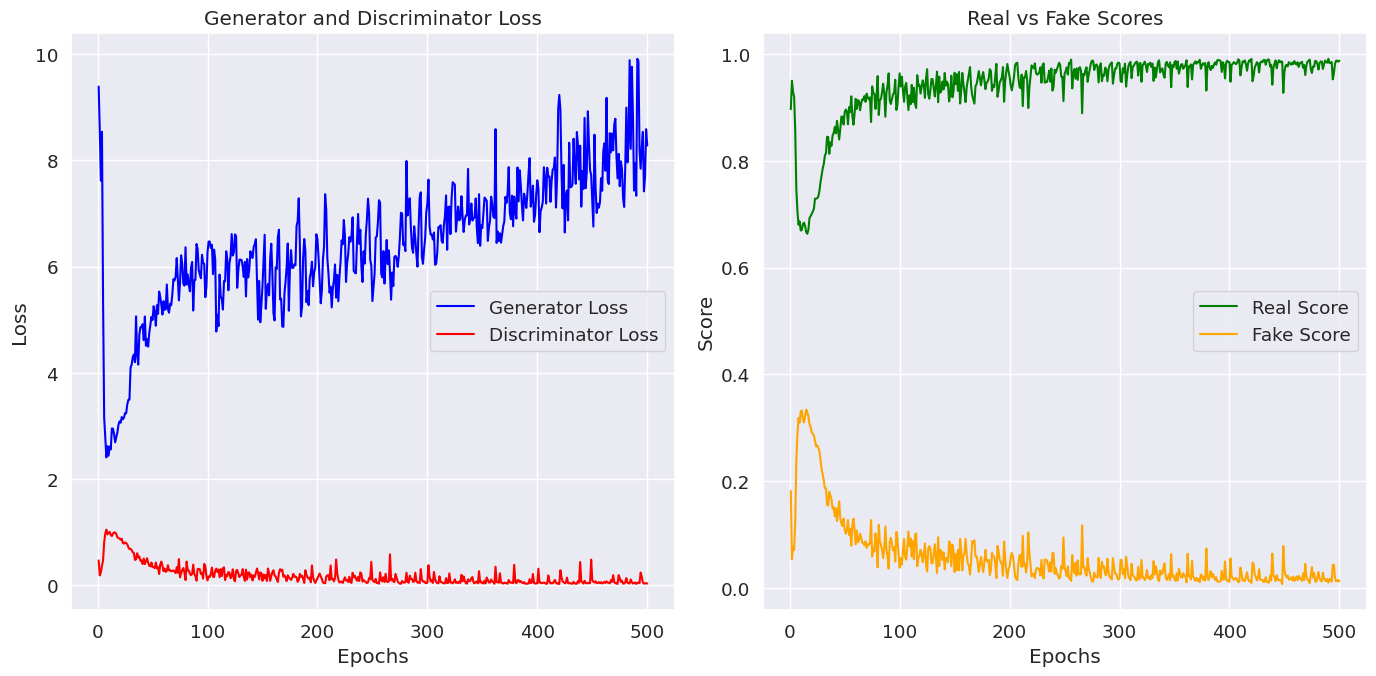

In [23]:
def plot_training_progress(losses_g, losses_d, real_scores, fake_scores):
    epochs = len(losses_g)
    x = list(range(1, epochs + 1))

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, losses_g, label="Generator Loss", color='blue')
    plt.plot(x, losses_d, label="Discriminator Loss", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, real_scores, label="Real Score", color='green')
    plt.plot(x, fake_scores, label="Fake Score", color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Real vs Fake Scores')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_progress(*history)


In [24]:
def save_model(model, filepath="gan_model.pth"):
    torch.save({
        "discriminator_state_dict": model["discriminator"].state_dict(),
        "generator_state_dict": model["generator"].state_dict(),
    }, filepath)
    print(f"Model saved to {filepath}")

save_model(model)

Model saved to gan_model.pth


## Part 3. Generating images

In [25]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

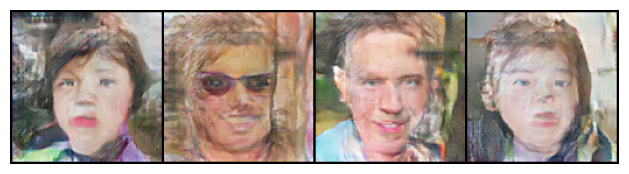

In [26]:
def show_images(generated):
    generated = generated.cpu().detach()  
    grid = make_grid(generated, nrow=n_images, normalize=True) 
    npimg = grid.numpy()  

    plt.figure(figsize=(n_images * 2, 2))  
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.axis('off')  # Hide axes
    plt.show()

show_images(fake_images)

## Part 4. Leave-one-out-1-NN classifier accuracy 

### 4.1. accuracy 

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [28]:
def generate_images(generator, num_images, latent_dim, device):
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, 1, 1, device=device)
        generated_images = generator(z).cpu().detach()
    return generated_images

def get_real_images(train_dataloader, num_images):
    real_images = []
    for images in train_dataloader:
        real_images.extend(images.cpu().numpy())
        if len(real_images) >= num_images:
            break
    return real_images[:num_images]

In [29]:
num_images = 1000
generated_images = generate_images(generator, num_images, latent_size, device)
real_images = get_real_images(train_dl, num_images)

In [30]:
def preprocess_images(images):
    return images.reshape(images.shape[0], -1) / 255.0

In [31]:
reshaped_generated = preprocess_images(generated_images)
reshaped_real = preprocess_images(np.array(real_images))

In [32]:
X = np.vstack((reshaped_generated, reshaped_real))
y = np.concatenate((np.zeros(num_images), np.ones(num_images)))

In [33]:
def evaluate_model(X, y):
    loo = LeaveOneOut()
    knn = KNeighborsClassifier(n_neighbors=1)
    accuracies = []
    

    for train_index, test_index in tqdm(loo.split(X), total=X.shape[0], desc="Leave-One-Out Progress", ncols=100):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    return np.mean(accuracies)

accuracy = evaluate_model(X, y)
print(f"Leave-One-Out Cross-Validation Accuracy: {accuracy:.4f}")

Leave-One-Out Progress: 100%|███████████████████████████████████| 2000/2000 [23:01<00:00,  1.45it/s]

Leave-One-Out Cross-Validation Accuracy: 0.6985


### 4.2. Vizualizing distributions

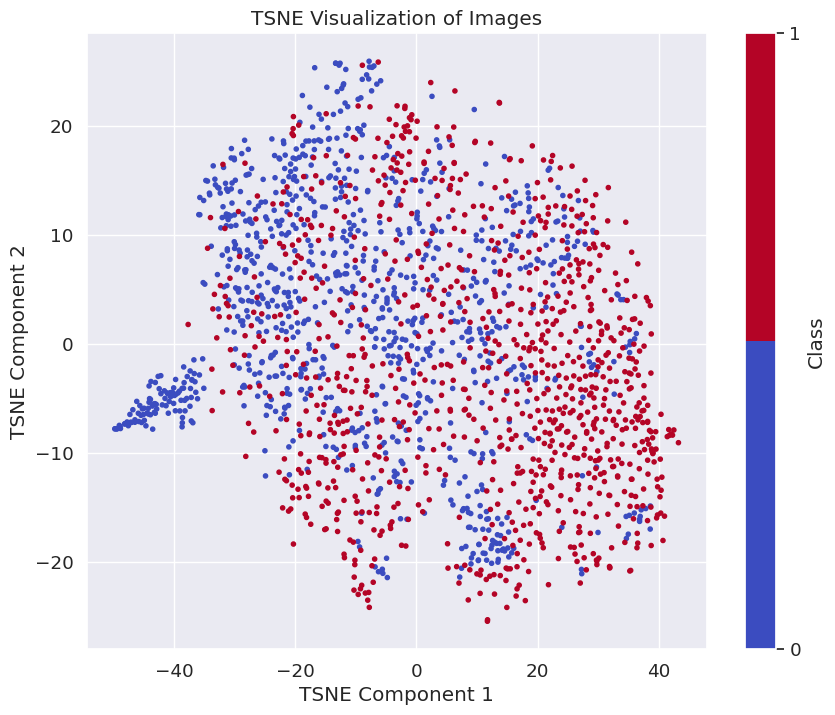

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=47)
all_images_2d = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(all_images_2d[:, 0], all_images_2d[:, 1], c=y, cmap=plt.cm.get_cmap("coolwarm", 2), marker='.')
plt.colorbar(ticks=range(2), label='Class')
plt.title('TSNE Visualization of Images')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

# Part 5. Conclusion